## Problem Set 3

### Justin Coker

In [1]:
#note: folder "ancillary files" must be in the current working directory for this notebook to run.

import pandas as pd

data = pd.read_stata("ancillary files/PS3_data.dta")

## Explore Data

We only have Heads of House Hold in our data

In [2]:
set(data.relhh.values)

{'Head'}

But, we have both males and females

In [3]:
set(data.hsex.values)

{1.0, 2.0}

We have only race = 1, 2, 3, 8, nan

In [4]:
data.hrace.unique() 
# note that we have no hispanics in our data, meaning a coefficient on hispanic dummy variable cannot be estimated.

array([  1.,   2.,   3.,  nan,   8.])

We also have individuals who worked 0 hours

In [5]:
min(set(data.hannhrs.values))

0.0

## Clean the data

In [6]:
#dropping female heads of house hold
data = data[data.hsex == 1]

#dropping individuals younger than 25, or older than 60
data = data[data.age <= 60]
data = data[data.age >= 25]

#dropping individuals with nan hours or annual income
data = data.dropna(how='any', subset=['hannhrs', 'hlabinc'])

#dropping individuals with 0 annual hours worked (to avoid +inf hourly wage)
data = data[data.hannhrs >0]

#dropping individuals with race, educ = nan
data = data.dropna(how='any', subset=['hrace', 'hyrsed'])



In [7]:
#create hourly wage variable = annual income/annual hours
data['hwage'] = data.hlabinc/data.hannhrs

#dropping individuals with wage <= 7 
data = data[data.hwage > 7]

#creating race dummies

import numpy as np

data['black'] = np.where(data['hrace']==2, 1, 0)

data['hispanic'] = np.where(data['hrace']==5, 1, 0)

data['other'] = np.where(((data['hrace'] !=1 ) & (data['hrace'] != 2) & (data['hrace'] !=5)), 1, 0)

## Check the variables we just created:

In [8]:
print(set(data.hsex.values), 'Should be ==1 only')
print(min(set(data.hannhrs.values)), 'Hours should be non-zero')
print(min(set(data.hwage.values)), max(set(data.hwage.values)), 'wage should be >7 and finite')
print(min(set(data.age.values)), max(set(data.age.values)), 'age should be [25, 60]')
print(min(set(data.hyrsed.values)), max(set(data.hyrsed.values)), 'edu range')

{1.0} Should be ==1 only
2.0 Hours should be non-zero
7.00025 1717.33 wage should be >7 and finite
25.0 60.0 age should be [25, 60]
1.0 17.0 edu range


In [9]:
print(set(data.hrace.values), 'only have race = 1, 2, 3')

print(len(data.hrace[data.hrace == 2]), sum(data.black), 'These must match')

print(len(data.hrace[data.hrace == 5]), sum(data.hispanic), 'These must match')

print(len(data.hrace[(data.hrace != 1) & (data.hrace !=2) & (data.hrace != 5) ]), sum(data.other), 'These must match')

white = len(data) - sum(data.black) - sum(data.hispanic) - sum(data.other)
print(len(data.hrace[data.hrace == 1]), white, 'These must match')

print(len(data)) 

{1.0, 2.0, 3.0} only have race = 1, 2, 3
3217 3217 These must match
0 0 These must match
1285 1285 These must match
52560 52560 These must match
57062


In [10]:
#transforming wage into logs:

data['loghwage'] = np.log(data.hwage)

#selecting only the data we want to include in our model

model_data = data.loc[0:,['id68', 'year', 'loghwage', 'hyrsed', 'age', 'black',  'hispanic', 'other']]

## (Negative) log liklihood function

In [11]:
def norm_LL(B, sd, data, y, x, t, cons = True):
    '''
    This function returns the negative Log Likelihood of a linear model where observations are i.i.d. with 
    variance s^2 given parameters.
    
    Args:
        B: a (kx1) array of slope coefficients of the model 
        
        sd: the standard deviation of the error term in the model
        
        data: a pandas dataframe containing the model data in a panel format (individual over time)
        
        y: a str, which is the dataframe column name of the outcome variable
        
        
        x: a list of length k, the elements of which are the dataframe column names of the independent variables of the model. 
    
        t: the time period(s) of interest. a list which reflects the time of interest from the panel.
           assumes there is a column in the dataframe name 'year'
                
        cons: boolean True if you wish to have a constant in the model False otherwise. Default = True
    '''
    
    import numpy as np 
    
    #slice the data by the year(s) of interest
    use_data = data[data['year'].isin(t)]
     
    #define the Y vector determined by the column name passed as an arg
    outcome = np.matrix(use_data[list(y)])
    
    #adds a constant to the model depending on the value of cons passed as an arg.
    if cons == True:
        ind = np.matrix(use_data[x])
        constant = np.matrix(np.ones((len(ind), 1)))
        ind = np.append(constant, ind, 1)
        
    if cons == False:
        ind = np.matrix(use_data[x])
        
    #defines n based on the sliced data
    n = len(use_data)
    
    #defines the kx1 beta vector
    B = np.matrix(B).T
    


    #negative log likilihood function for use in optimization
    #np.dot((outcome - ind*B).T, (outcome - ind*B)) is (Y-Xb)'*(Y-Xb)
    
    LL = -1*((n*np.log(2*np.pi) - n*np.log(sd) - (1/sd))*(1/2) - np.dot((outcome - ind*B).T, (outcome - ind*B)))
    
    return LL



## Test the log liklihood function with arbitrary betas

In [12]:
B = np.array((.5,.5,.5,.5,0,.5))

sd = 1

y = ['loghwage']

x = ['hyrsed', 'age', 'black','hispanic', 'other']

t = [1986]

In [13]:
#runs the function using an arbitrary B vector to confirm that the defined matrices conform to matrix multiplication.
result = norm_LL(B, sd, model_data, y, x, t)
print(result)

[[ 1159679.43230115]]


## optimization routine

In [14]:
import scipy.optimize as opt


# parameters
B = np.array((.5,.5,.5,.5,.5))

sd = 1 #arbitrarily set to 1, doesn't impact the coef estimates only the SE's

y = ['loghwage'] #log wage is our outcome

x = ['hyrsed', 'age', 'black', 'other'] 
# there are 0 hispanic individuals in the data, therefore, this variable must be dropped.

#empty list to hold the coef estimates from the optimization routine
coefs = []

#loop over the years of interest: 1971, 1980, 1990, 2000
for el in [1971, 1980, 1990, 2000]:
    params = (sd, model_data, y, x, [el]) #parameters to pass as arguments to the LL function
    beta = opt.minimize(norm_LL, B, args = params, method = 'Nelder-Mead', tol = 1e-10, options={'maxiter': 5000})
    coefs.append(beta.x) #appends only coef estimates to the coefs list, useful for printing later
    print(el, beta) #prints all of the output for each year of interest

1971  final_simplex: (array([[ 1.55096379,  0.06687878,  0.01439146, -0.16388756,  0.03068777],
       [ 1.55096379,  0.06687878,  0.01439146, -0.16388756,  0.03068777],
       [ 1.55096379,  0.06687878,  0.01439146, -0.16388756,  0.03068777],
       [ 1.55096379,  0.06687878,  0.01439146, -0.16388756,  0.03068777],
       [ 1.55096379,  0.06687878,  0.01439146, -0.16388756,  0.03068777],
       [ 1.55096379,  0.06687878,  0.01439146, -0.16388756,  0.03068777]]), array([-1035.54516136, -1035.54516136, -1035.54516136, -1035.54516136,
       -1035.54516136, -1035.54516136]))
           fun: -1035.5451613582861
       message: 'Optimization terminated successfully.'
          nfev: 1111
           nit: 640
        status: 0
       success: True
             x: array([ 1.55096379,  0.06687878,  0.01439146, -0.16388756,  0.03068777])
1980  final_simplex: (array([[ 1.61308836,  0.06755585,  0.01269854, -0.10273616,  0.01351125],
       [ 1.61308836,  0.06755585,  0.01269854, -0.10273616,  0.

In [15]:
#prints model estimates for each year in linear form.

yrs = ['1971', '1980', '1990', '2000']
coefs_r = np.around(coefs, decimals = 5) #round for visualization
for i in range(len(yrs)):
    print('')
    print('The fitted model in', yrs[i], 'is given by:')
    print(coefs_r[i][0],' + ', coefs_r[i][1], '* Educ + ', coefs_r[i][2],'* Age + ', coefs_r[i][3], '* Black + ', coefs_r[i][4], '* OtherRaces + e' )


The fitted model in 1971 is given by:
1.55096  +  0.06688 * Educ +  0.01439 * Age +  -0.16389 * Black +  0.03069 * OtherRaces + e

The fitted model in 1980 is given by:
1.61309  +  0.06756 * Educ +  0.0127 * Age +  -0.10274 * Black +  0.01351 * OtherRaces + e

The fitted model in 1990 is given by:
1.11858  +  0.09756 * Educ +  0.01347 * Age +  -0.17202 * Black +  -0.05971 * OtherRaces + e

The fitted model in 2000 is given by:
1.16169  +  0.10915 * Educ +  0.01099 * Age +  -0.24604 * Black +  -0.06073 * OtherRaces + e


# Note that the coefficient on Educ is interpretted as: a 1 unit change in Education (i.e. one additional year) results in a $\beta_1$ %$\Delta$ in wages, on average.

## Testing against the OLS estimator: $(X^\prime X)^{-1}X^\prime  y$

In [16]:
#prints the coeficient estimates given by the OLS estimator: 
#These should be identical (or very close) to the estimates from the optimization routine

OLS = []
for el in [1971, 1980, 1990, 2000]:
    
    use_data = model_data[model_data['year'] == el]
    
    ind = np.matrix(use_data[['hyrsed', 'age', 'black', 'other']])
    
    constant = np.matrix(np.ones((len(ind), 1))) #creates a vector of ones for the constant
    
    ind = np.append(constant, ind, 1) #adds the constant column to the X matrix
    
    outcome = np.matrix(use_data[y])
    
    OLS.append(np.linalg.inv((ind.T*ind))*ind.T*outcome)
    print(el, np.linalg.inv((ind.T*ind))*ind.T*outcome) #(X'X)^-1*X'Y 
    
    

1971 [[ 1.55096381]
 [ 0.06687878]
 [ 0.01439146]
 [-0.16388756]
 [ 0.03068777]]
1980 [[ 1.61308834]
 [ 0.06755585]
 [ 0.01269854]
 [-0.10273616]
 [ 0.01351126]]
1990 [[ 1.11858494]
 [ 0.09755808]
 [ 0.0134656 ]
 [-0.17202429]
 [-0.05971249]]
2000 [[ 1.16169085]
 [ 0.10915436]
 [ 0.01099353]
 [-0.24604481]
 [-0.06073245]]


In [17]:
# Calculates the maximum symmetric difference between the vectors of OLS and MLE estimates:

for i in range(len(coefs)):
    print((np.matrix(coefs[i]) - OLS[i].T).max())
    
print('We can see that our MLE estimates are practically identical to the OLS estimates.') 


2.02505501257e-09
1.70367451258e-08
1.97308404962e-08
5.25139594032e-08
We can see that our MLE estimates are practically identical to the OLS estimates.


## Checking against output from Stata reg command

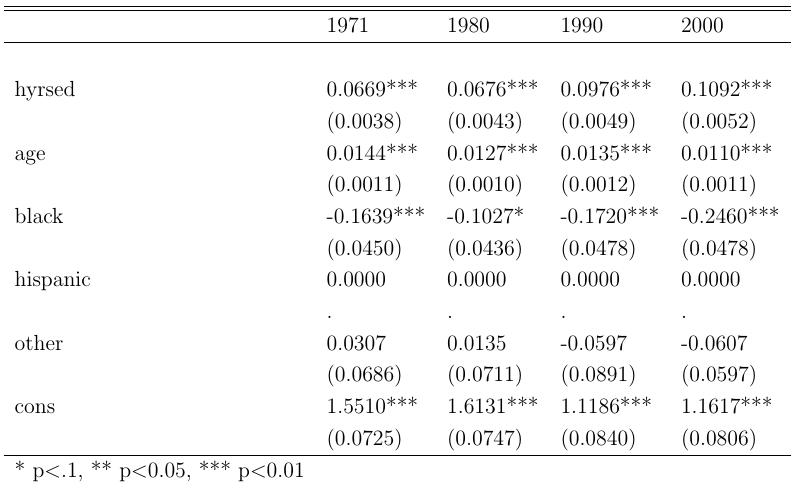

In [18]:
#Displays formatted output from running the same regressions in stata
#We see that the rounded coefficient estimates are identical

from IPython.display import Image
Image("ancillary files/stata_output.png")

## The graph below shows how the returns to education have changed over time

### As expected, the returns to education appear to be increasing

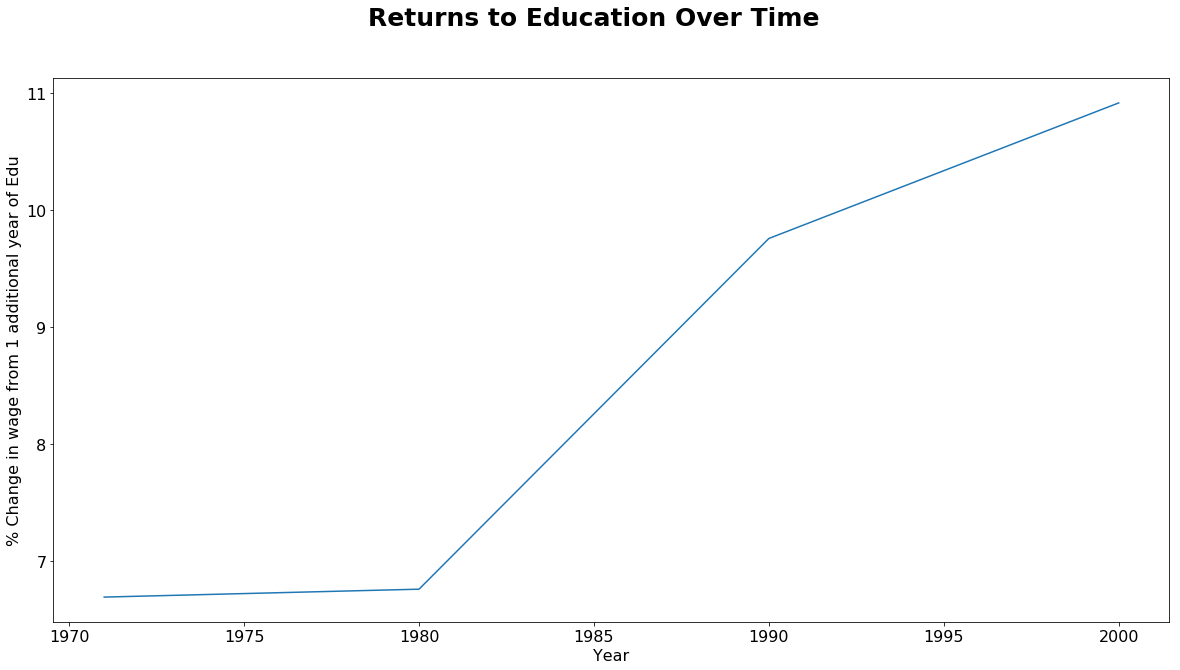

In [19]:
import matplotlib.pyplot as plt


plt.rcParams.update({'font.size': 16})



x_axis = []
for i in range(len(coefs)):
    x_axis.append(coefs[i][1]*100)
x_axis = np.array(x_axis)
y_axis = np.array(['1971', '1980', '1990', '2000'])

fig = plt.figure(figsize=(20,10))
fig.suptitle('Returns to Education Over Time', fontsize=25, fontweight='bold')
ax = fig.add_subplot(111)
ax.set_xlabel('Year')
ax.set_ylabel('% Change in wage from 1 additional year of Edu')
ax.plot(y_axis, x_axis)
plt.show()